In [145]:
import pandas as pd
import unicodedata

from tqdm import tqdm
tqdm.pandas(desc="Progress")

In [5]:
import os
path = os.getcwd()
path

'/Users/ryanphung/Projects/Linguistics/chinese-hanviet'

In [77]:
# Step 1: read Chinese words from a frequency list
df_chinese_words = pd.read_csv('inputs/leeds.txt', sep=' ', names=['rank','frequency','word'], skiprows=[0,1,2,3])
df_chinese_words

,rank,frequency,word
0,1,66293.28,，
1,2,45402.97,的
2,3,14216.88,了
3,4,12935.94,我
4,5,11879.45,一
...,...,...,...
49995,49996,0.63,陕西人
49996,49997,0.63,封建制度
49997,49998,0.63,牛郎织女
49998,49999,0.63,着眼点


In [78]:
# add pinyin

import pinyin
print(pinyin.get('你好'))

df_chinese_words['pinyin'] = df_chinese_words.progress_apply(
    lambda x:pinyin.get(str(x['word'])),
    axis=1
)

nǐhǎo


Progress: 100%|██████████| 50000/50000 [00:01<00:00, 28388.57it/s]


In [79]:
# add traditional

df_chinese_words['traditional'] = df_chinese_words.progress_apply(
    lambda x:chinese_converter.to_traditional(str(x['word'])),
    axis=1
)

Progress: 100%|██████████| 50000/50000 [00:01<00:00, 42591.68it/s]


In [206]:
# read Thieu Chuu character dictionary

df_chars_thieuchuu = pd.read_csv('inputs/thieuchuu.txt', sep=r'=|\s\[|\]', names=['character', 'hanviet', 'pinyin', 'meaning'], engine='python')
df_chars_thieuchuu = df_chars_thieuchuu.drop(columns=['pinyin', 'meaning'])
df_chars_thieuchuu

,character,hanviet
0,一,nhất
1,丁,"đinh, chênh"
2,七,thất
3,万,"vạn, mặc"
4,丈,trượng
...,...,...
10021,龟,"quy, cưu, quân"
10022,龝,thu
10023,龠,"dược, thược"
10024,龡,xúy


In [208]:
# read phienam.txt

df_chars_phienam = pd.read_csv('inputs/phienam.txt', sep=r'=', names=['character', 'hanviet'])
df_chars_phienam

,character,hanviet
0,第,đệ
1,九,cửu
2,章,chương
3,以,dĩ
4,战,chiến
...,...,...
11406,生,sinh
11407,噌,tạch
11408,噼,hoa
11409,哐,bang


In [278]:
# merge the 2 sources of Han Viet sounds

df_chars = df_chars_thieuchuu.merge(df_chars_phienam, on='character', how='outer', suffixes=('_thieuchuu', '_phienam'))
df_chars

,character,hanviet_thieuchuu,hanviet_phienam
0,一,nhất,nhất
1,丁,"đinh, chênh",đinh
2,七,thất,thất
3,万,"vạn, mặc",vạn
4,万,vạn,vạn
...,...,...,...
11552,乜,NaN,nga
11553,噌,NaN,tạch
11554,噼,NaN,hoa
11555,哐,NaN,bang


In [279]:
import math

def is_empty_string_or_nan(a):
    return not a or (isinstance(a, float) and math.isnan(a))

def merge_list(a, b):
    return ', '.join(list(set(
        ([] if is_empty_string_or_nan(a) else str(a).split(', ')) +
        ([] if is_empty_string_or_nan(b) else str(b).split(', '))
    )))

print(merge_list('đinh, chênh', 'đinh'))
print(merge_list(None, 'hoa'))
print(merge_list('hoa', None))
print(merge_list(None, None))
print(merge_list('hoa', float('NaN')))

đinh, chênh
hoa
hoa

hoa


In [280]:
df_chars['hanviet'] = df_chars.progress_apply(lambda x:merge_list(x['hanviet_thieuchuu'], x['hanviet_phienam']), axis=1)
df_chars = df_chars.drop(columns=['hanviet_thieuchuu', 'hanviet_phienam'])
df_chars

Progress: 100%|██████████| 11557/11557 [00:00<00:00, 33708.81it/s]


,character,hanviet
0,一,nhất
1,丁,"đinh, chênh"
2,七,thất
3,万,"mặc, vạn"
4,万,vạn
...,...,...
11552,乜,nga
11553,噌,tạch
11554,噼,hoa
11555,哐,bang


In [281]:
# Function to get Han Viet sound from Chinese word
def get_hanviet(word):
    result = []
    
    for c in word:
        df_of_c = df_chars[df_chars['character'] == c]
        if df_of_c.empty:
            return
        c_hv = df_of_c['hanviet'].values[0].split(', ')
        if (len(result) == 0):
            result = c_hv
        else:
            row = result
            result = []
            for i in row:
                for j in c_hv:
                    result.append(' '.join([i, j]))
    
    return result

# Test
print(get_hanviet('利害'))
print(get_hanviet('我们'))
print(get_hanviet('看看'))
print(get_hanviet('国际'))
print(get_hanviet('国際')) #Traditional too!
print(get_hanviet('怎么办')) #Should get from traditional
print(get_hanviet('怎麼辦'))
print(get_hanviet('有着')) # Should combine output from simplified and traditional
print(get_hanviet('通过')) # Oops, thông quá?
print(get_hanviet('通過'))

['lợi hại', 'lợi hạt']
['ngã môn']
['khán khán']
['quốc tế']
['quốc tế']
['chẩm yêu bạn', 'chẩm yêu biện']
['chẩm ma bạn', 'chẩm ma biện']
['dựu trứ', 'dựu khán', 'hữu trứ', 'hữu khán']
['thông quá']
['thông quá', 'thông qua']


In [285]:
import chinese_converter

# Function to get Han Viet sound from Chinese word (by converting to traditional Chinese first)
def get_full_hanviet(word):
    result = get_hanviet(word)
    traditional = chinese_converter.to_traditional(word)
    
    if traditional != word:
        result_traditional = get_hanviet(traditional)
        result = (result or []) + (result_traditional or [])
        result = list(set(result))
    
    return ', '.join(result) if result else None

# Test
print(get_full_hanviet(','))
print(get_full_hanviet('利害'))
print(get_full_hanviet('我们'))
print(get_full_hanviet('看看'))
print(get_full_hanviet('国际'))
print(get_full_hanviet('国際')) #Traditional too!
print(get_full_hanviet('怎么办')) #Should get from traditional
print(get_full_hanviet('怎麼辦'))
print(get_full_hanviet('有着')) # Should combine output from simplified and traditional
print(get_full_hanviet('通过'))
print(get_full_hanviet('通過'))
print(get_full_hanviet('全部')) # missed out in Thieu Chuu dictionary but exist in phienam.txt
print(get_full_hanviet('研究')) # Thieu Chuu dictionary uses a character variant but phienam.txt should have it

None
lợi hại, lợi hạt
ngã môn
khán khán
quốc tế
quốc tế
chẩm ma biện, chẩm ma bạn, chẩm yêu biện, chẩm yêu bạn
chẩm ma bạn, chẩm ma biện
hữu trứ, dựu khán, dựu trứ, hữu khán
thông quá, thông qua
thông quá, thông qua
toàn bộ
nghiên cứu


In [286]:
# Step 2: find all Han Viet sound of these Chinese words

df_chinese_words['hanviet'] = df_chinese_words.progress_apply(lambda x:get_full_hanviet(str(x['word'])), axis=1)
df_chinese_words

Progress: 100%|██████████| 50000/50000 [04:23<00:00, 190.02it/s]


,rank,frequency,word,pinyin,traditional,hanviet
0,1,66293.28,，,，,，,None
1,2,45402.97,的,de,的,"để, đích"
2,3,14216.88,了,le,瞭,"liễu, liệu"
3,4,12935.94,我,wǒ,我,ngã
4,5,11879.45,一,yī,一,nhất
...,...,...,...,...,...,...
49995,49996,0.63,陕西人,shǎnxīrén,陝西人,"thiểm tê nhân, thiểm tây nhân"
49996,49997,0.63,封建制度,fēngjiànzhìdù,封建制度,"phong kiển chế độ, phong kiển chế đạc, phong k..."
49997,49998,0.63,牛郎织女,níulángzhīnv̌,牛郎織女,"ngưu lang xí nứ, ngưu lang chức nữ, ngưu lang ..."
49998,49999,0.63,着眼点,zháoyǎndiǎn,著眼點,"trứ nhãn điểm, khán nhãn điểm"


In [287]:
df_chinese_words_with_hanviet = df_chinese_words#[df_chinese_words['hanviet'].notnull()]
df_chinese_words_with_hanviet

,rank,frequency,word,pinyin,traditional,hanviet
0,1,66293.28,，,，,，,None
1,2,45402.97,的,de,的,"để, đích"
2,3,14216.88,了,le,瞭,"liễu, liệu"
3,4,12935.94,我,wǒ,我,ngã
4,5,11879.45,一,yī,一,nhất
...,...,...,...,...,...,...
49995,49996,0.63,陕西人,shǎnxīrén,陝西人,"thiểm tê nhân, thiểm tây nhân"
49996,49997,0.63,封建制度,fēngjiànzhìdù,封建制度,"phong kiển chế độ, phong kiển chế đạc, phong k..."
49997,49998,0.63,牛郎织女,níulángzhīnv̌,牛郎織女,"ngưu lang xí nứ, ngưu lang chức nữ, ngưu lang ..."
49998,49999,0.63,着眼点,zháoyǎndiǎn,著眼點,"trứ nhãn điểm, khán nhãn điểm"


In [288]:
# df_chinese_words_with_hanviet.to_csv('outputs/chinese-words-with-hanviet.tsv', sep='\t', index_label=['no'])

In [289]:
# Read a Viet Phrases dictionary

df_vietphrases = pd.read_csv('inputs/vietphrases.txt', sep='=', names=['phrase', 'meaning'])
df_vietphrases

,phrase,meaning
0,充满希望的跋涉比到达目的地更能给人乐趣,sung mãn hi vọng đích bạt thiệp bỉ đáo đạt mục...
1,充滿希望的跋涉比到達目的地更能給人樂趣,sung mãn hi vọng đích bạt thiệp bỉ đáo đạt mục...
2,来的时候是这么来的走的时候也就这么走了,khi tới như thế nào/khi đi cũng như vậy
3,无一事而不学无一时而不学无一处而不得,vô nhất sự nhi bất học/vô nhất thì nhi bất học...
4,無一事而不學無一時而不學無一處而不得,vô nhất sự nhi bất học/vô nhất thì nhi bất học...
...,...,...
107306,鹅,nga/ngan/ngỗng
107307,麻,ma/tê dại
107308,黏,dính
107309,鼻,mũi


In [293]:
df_chinese_words_with_hanviet_and_meaning = df_chinese_words_with_hanviet.merge(df_vietphrases, left_on='word', right_on='phrase', how='inner')
df_chinese_words_with_hanviet_and_meaning

,rank,frequency,word,pinyin,traditional,hanviet,phrase,meaning
0,2,45402.97,的,de,的,"để, đích",的,đích
1,3,14216.88,了,le,瞭,"liễu, liệu",了,/liễu
2,4,12935.94,我,wǒ,我,ngã,我,ta
3,5,11879.45,一,yī,一,nhất,一,một/nhất
4,6,9854.95,在,zài,在,tại,在,ở
...,...,...,...,...,...,...,...,...
30028,49984,0.63,白肉,báiròu,白肉,"bạch nhụ, bạch nậu, bạch nhục",白肉,thịt luộc/thịt lợn luộc
30029,49985,0.63,成林,chénglín,成林,thành lâm,成林,thành rừng
30030,49989,0.63,交合,jiāohé,交合,"giao cáp, giao hợp",交合,giao hợp/tính giao/giao cấu
30031,49994,0.63,暖烘烘,nuǎnhōnghōng,暖烘烘,noãn hồng hồng,暖烘烘,ấm áp dễ chịu


In [294]:
# Function to find if the Han Viet sounds match a word in the meaning

def match(a, b):
    if not a or not b:
        return
    for a_part in a.split(', '):
        if a_part.lower() in map(lambda x:x.lower(), b.split('/')):
            return a_part
    
print(match('thành lâm', 'thành rừng'))
print(match('chế độ, chế đạc', 'chế độ'))
print(match('giao hợp, giao cáp', 'giao hợp/tính giao/giao cấu'))
print(match('bắc kinh', 'Bắc Kinh'))

None
chế độ
giao hợp
bắc kinh


In [295]:
df_chinese_words_with_hanviet_and_meaning['matched'] = df_chinese_words_with_hanviet_and_meaning.progress_apply(
    lambda x:match(str(x['hanviet']), str(x['meaning'])),
    axis=1
)
df_chinese_words_with_hanviet_and_meaning

Progress: 100%|██████████| 30033/30033 [00:00<00:00, 36057.62it/s]


,rank,frequency,word,pinyin,traditional,hanviet,phrase,meaning,matched
0,2,45402.97,的,de,的,"để, đích",的,đích,đích
1,3,14216.88,了,le,瞭,"liễu, liệu",了,/liễu,liễu
2,4,12935.94,我,wǒ,我,ngã,我,ta,None
3,5,11879.45,一,yī,一,nhất,一,một/nhất,nhất
4,6,9854.95,在,zài,在,tại,在,ở,None
...,...,...,...,...,...,...,...,...,...
30028,49984,0.63,白肉,báiròu,白肉,"bạch nhụ, bạch nậu, bạch nhục",白肉,thịt luộc/thịt lợn luộc,None
30029,49985,0.63,成林,chénglín,成林,thành lâm,成林,thành rừng,None
30030,49989,0.63,交合,jiāohé,交合,"giao cáp, giao hợp",交合,giao hợp/tính giao/giao cấu,giao hợp
30031,49994,0.63,暖烘烘,nuǎnhōnghōng,暖烘烘,noãn hồng hồng,暖烘烘,ấm áp dễ chịu,None


In [306]:
df_multisyllabic = df_chinese_words_with_hanviet_and_meaning.drop(
    df_chinese_words_with_hanviet_and_meaning[df_chinese_words_with_hanviet_and_meaning['word'].str.len() == 1].index
)
df_multisyllabic['chinese_rank'] = df_multisyllabic.reset_index().index
df_multisyllabic

,rank,frequency,word,pinyin,traditional,hanviet,phrase,meaning,matched,chinese_rank
20,25,2837.94,我们,wǒmen,我們,ngã môn,我们,chúng ta/chúng tôi/chúng tao/chúng tớ,None,0
26,32,2157.07,没有,méiyǒu,沒有,"một hữu, một dựu",没有,không có/không/không bằng/không đủ/không tới/k...,None,1
34,42,1921.32,自己,zìjǐ,自己,tự kỷ,自己,chính mình/chính/tự mình/bản thân/mình/nhà,None,2
39,48,1674.90,他们,tāmen,他們,tha môn,他们,bọn họ/chúng nó/họ,None,3
49,60,1512.01,什么,shíyāo,什麼,"thập ma, thập yêu",什么,cái gì/gì/nào/gì đó/nhậm chỉ/mọi thứ/nấy/cái q...,None,4
...,...,...,...,...,...,...,...,...,...,...
30028,49984,0.63,白肉,báiròu,白肉,"bạch nhụ, bạch nậu, bạch nhục",白肉,thịt luộc/thịt lợn luộc,None,28952
30029,49985,0.63,成林,chénglín,成林,thành lâm,成林,thành rừng,None,28953
30030,49989,0.63,交合,jiāohé,交合,"giao cáp, giao hợp",交合,giao hợp/tính giao/giao cấu,giao hợp,28954
30031,49994,0.63,暖烘烘,nuǎnhōnghōng,暖烘烘,noãn hồng hồng,暖烘烘,ấm áp dễ chịu,None,28955


In [308]:
df_matched = df_multisyllabic.drop(
    df_multisyllabic[df_multisyllabic['matched'].isnull()].index
)
df_matched['index'] = df_matched.reset_index().index + 1
df_matched

,rank,frequency,word,pinyin,traditional,hanviet,phrase,meaning,matched,chinese_rank,index
57,68,1332.15,可以,kěyǐ,可以,"khắc dĩ, khả dĩ",可以,có thể/khả dĩ/có khả năng/có năng lực/cho phép...,khả dĩ,5,1
66,81,1106.78,中国,zhōngguó,中國,"trúng quốc, trung quốc",中国,Trung Quốc/Trung Hoa Trung Quốc/China/nước cộn...,trung quốc,8,2
81,97,916.48,现在,xiànzài,現在,hiện tại,现在,hiện tại/hiện nay/bây giờ,hiện tại,13,3
88,105,831.20,时间,shíjiān,時間,"thời gian, thì gian",时间,thời gian/giờ/khoảng thời gian/thời điểm,thời gian,16,4
96,113,775.81,问题,wèntí,問題,vấn đề,问题,vấn đề/câu hỏi/đề hỏi/quan trọng/mấu chốt/chuy...,vấn đề,18,5
...,...,...,...,...,...,...,...,...,...,...,...
30018,49948,0.63,飞毛腿,fēimáotǔi,飛毛腿,"phi mao thối, phi mô thối",飞毛腿,phi mao thối/chạy nhanh/nhanh chân/cặp giò đi ...,phi mao thối,28942,8434
30019,49951,0.63,民以食为天,mínyǐshíwèitiān,民以食為天,"dân dĩ thực vi thiên, dân dĩ tự vi thiên",民以食为天,dân dĩ thực vi thiên,dân dĩ thực vi thiên,28943,8435
30022,49968,0.63,谢恩,xièēn,謝恩,tạ ân,谢恩,tạ ơn/tạ ân,tạ ân,28946,8436
30024,49974,0.63,尧舜,yáoshùn,堯舜,nghiêu thuấn,尧舜,Nghiêu Thuấn,nghiêu thuấn,28948,8437


In [309]:
df_matched.to_csv('outputs/chinese-hanviet-cognates.tsv', sep='\t', index=False, columns=['index', 'chinese_rank', 'frequency', 'word', 'traditional', 'pinyin', 'matched', 'meaning'])

In [311]:
df_not_matched = df_multisyllabic.drop(
    df_multisyllabic[df_multisyllabic['matched'].notnull()].index
)
df_not_matched['index'] = df_not_matched.reset_index().index + 1
df_not_matched

,rank,frequency,word,pinyin,traditional,hanviet,phrase,meaning,matched,chinese_rank,index
20,25,2837.94,我们,wǒmen,我們,ngã môn,我们,chúng ta/chúng tôi/chúng tao/chúng tớ,None,0,1
26,32,2157.07,没有,méiyǒu,沒有,"một hữu, một dựu",没有,không có/không/không bằng/không đủ/không tới/k...,None,1,2
34,42,1921.32,自己,zìjǐ,自己,tự kỷ,自己,chính mình/chính/tự mình/bản thân/mình/nhà,None,2,3
39,48,1674.90,他们,tāmen,他們,tha môn,他们,bọn họ/chúng nó/họ,None,3,4
49,60,1512.01,什么,shíyāo,什麼,"thập ma, thập yêu",什么,cái gì/gì/nào/gì đó/nhậm chỉ/mọi thứ/nấy/cái q...,None,4,5
...,...,...,...,...,...,...,...,...,...,...,...
30027,49983,0.63,进香,jìnxiāng,進香,tiến hương,进香,dâng hương/thắp hương/hành hương,None,28951,20515
30028,49984,0.63,白肉,báiròu,白肉,"bạch nhụ, bạch nậu, bạch nhục",白肉,thịt luộc/thịt lợn luộc,None,28952,20516
30029,49985,0.63,成林,chénglín,成林,thành lâm,成林,thành rừng,None,28953,20517
30031,49994,0.63,暖烘烘,nuǎnhōnghōng,暖烘烘,noãn hồng hồng,暖烘烘,ấm áp dễ chịu,None,28955,20518


In [312]:
df_not_matched.to_csv('outputs/chinese-hanviet-non-cognates.tsv', sep='\t', index=False, columns=['index', 'chinese_rank', 'frequency', 'word', 'traditional', 'pinyin', 'hanviet', 'meaning'])

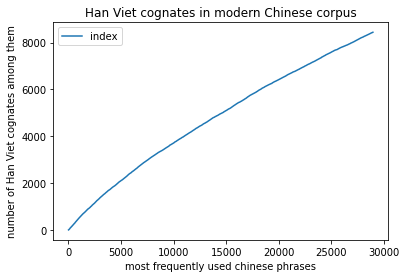

In [313]:
ax = df_matched.plot(x="chinese_rank", y="index",
                title="Han Viet cognates in modern Chinese corpus",
                xlabel="most frequently used chinese phrases",
                ylabel="number of Han Viet cognates among them"
               )

In [314]:
fig = ax.get_figure()
fig.savefig('outputs/chart.jpg')